In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
# Function to load and preprocess images
def load_images_from_directory(base_path, emotion_labels, img_size=(48, 48)):
    faces = []
    emotions = []
    for emotion, label in emotion_labels.items():
        emotion_folder = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_folder):
            if filename.endswith('.png') or filename.endswith('.jpg'):
                img_path = os.path.join(emotion_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                faces.append(img.astype('float32'))
                emotions.append(label)
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = np.asarray(emotions)
    emotions = np.eye(len(emotion_labels))[emotions]  # One-hot encode
    return faces, emotions

In [3]:
# Define emotion labels
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'sad': 3, 'happy': 4, 'neutral': 5, 'surprise': 6}

In [4]:
# Load FER-2013 dataset
faces_fer, emotions_fer = load_images_from_directory(r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\train", emotion_labels)

# Load kaggle dataset
faces_ck, emotions_ck = load_images_from_directory(r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\archive\images\images\train", emotion_labels)

In [5]:
# Normalize pixel values to the range [0, 1]
faces_fer /= 255.0
faces_ck /= 255.0

In [6]:
# Combine datasets
faces_combined = np.concatenate((faces_fer, faces_ck), axis=0)
emotions_combined = np.concatenate((emotions_fer, emotions_ck), axis=0)

# Shuffle the combined dataset
faces_combined, emotions_combined = shuffle(faces_combined, emotions_combined, random_state=42)

In [7]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(faces_combined, emotions_combined, test_size=0.2, random_state=42)

In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [9]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes for emotion detection
])

In [10]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 64)        0

In [12]:
# Train the model
batch_size = 32
epochs = 200

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs
)

Epoch 1/200
1438/1438 [==============================] - 56s 39ms/step - loss: 1.8207 - accuracy: 0.2443 - val_loss: 1.8219 - val_accuracy: 0.2551
Epoch 2/200
1438/1438 [==============================] - 58s 40ms/step - loss: 1.7974 - accuracy: 0.2486 - val_loss: 1.7992 - val_accuracy: 0.2567
Epoch 3/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.7898 - accuracy: 0.2518 - val_loss: 1.7925 - val_accuracy: 0.2642
Epoch 4/200
1438/1438 [==============================] - 61s 43ms/step - loss: 1.7802 - accuracy: 0.2593 - val_loss: 1.7692 - val_accuracy: 0.2688
Epoch 5/200
1438/1438 [==============================] - 62s 43ms/step - loss: 1.7675 - accuracy: 0.2662 - val_loss: 1.7318 - val_accuracy: 0.2924
Epoch 6/200
1438/1438 [==============================] - 62s 43ms/step - loss: 1.7566 - accuracy: 0.2763 - val_loss: 1.7021 - val_accuracy: 0.3126
Epoch 7/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.7426 - accuracy: 0.2835 - val_loss: 1

1438/1438 [==============================] - 63s 44ms/step - loss: 1.3661 - accuracy: 0.4807 - val_loss: 1.1784 - val_accuracy: 0.5508
Epoch 57/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.3684 - accuracy: 0.4796 - val_loss: 1.1612 - val_accuracy: 0.5607
Epoch 58/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.3689 - accuracy: 0.4789 - val_loss: 1.1583 - val_accuracy: 0.5622
Epoch 59/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.3613 - accuracy: 0.4831 - val_loss: 1.1494 - val_accuracy: 0.5644
Epoch 60/200
1438/1438 [==============================] - 65s 45ms/step - loss: 1.3549 - accuracy: 0.4853 - val_loss: 1.1535 - val_accuracy: 0.5646
Epoch 61/200
1438/1438 [==============================] - 64s 44ms/step - loss: 1.3581 - accuracy: 0.4818 - val_loss: 1.1525 - val_accuracy: 0.5646
Epoch 62/200
1438/1438 [==============================] - 64s 45ms/step - loss: 1.3559 - accuracy: 0.4860 - val_loss: 1.1567 

1438/1438 [==============================] - 62s 43ms/step - loss: 1.2792 - accuracy: 0.5163 - val_loss: 1.0781 - val_accuracy: 0.5912
Epoch 112/200
1438/1438 [==============================] - 62s 43ms/step - loss: 1.2782 - accuracy: 0.5165 - val_loss: 1.1007 - val_accuracy: 0.5847
Epoch 113/200
1438/1438 [==============================] - 65s 45ms/step - loss: 1.2726 - accuracy: 0.5169 - val_loss: 1.0763 - val_accuracy: 0.5929
Epoch 114/200
1438/1438 [==============================] - 65s 45ms/step - loss: 1.2762 - accuracy: 0.5162 - val_loss: 1.0663 - val_accuracy: 0.5988
Epoch 115/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.2697 - accuracy: 0.5210 - val_loss: 1.0833 - val_accuracy: 0.5949
Epoch 116/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.2781 - accuracy: 0.5143 - val_loss: 1.0678 - val_accuracy: 0.5949
Epoch 117/200
1438/1438 [==============================] - 60s 42ms/step - loss: 1.2671 - accuracy: 0.5213 - val_loss: 1

1438/1438 [==============================] - 65s 45ms/step - loss: 1.2346 - accuracy: 0.5358 - val_loss: 1.0359 - val_accuracy: 0.6130
Epoch 167/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.2383 - accuracy: 0.5306 - val_loss: 1.0374 - val_accuracy: 0.6086
Epoch 168/200
1438/1438 [==============================] - 63s 44ms/step - loss: 1.2363 - accuracy: 0.5332 - val_loss: 1.0305 - val_accuracy: 0.6116
Epoch 169/200
1438/1438 [==============================] - 64s 45ms/step - loss: 1.2359 - accuracy: 0.5314 - val_loss: 1.0292 - val_accuracy: 0.6129
Epoch 170/200
1438/1438 [==============================] - 64s 45ms/step - loss: 1.2353 - accuracy: 0.5342 - val_loss: 1.0305 - val_accuracy: 0.6105
Epoch 171/200
1438/1438 [==============================] - 64s 45ms/step - loss: 1.2273 - accuracy: 0.5340 - val_loss: 1.0374 - val_accuracy: 0.6102
Epoch 172/200
1438/1438 [==============================] - 64s 44ms/step - loss: 1.2341 - accuracy: 0.5347 - val_loss: 1

In [13]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


360/360 [==============================] - 4s 10ms/step - loss: 1.0328 - accuracy: 0.6124
Validation Loss: 1.0327908992767334
Validation Accuracy: 0.6123761534690857


In [14]:
# Save the model
model.save('emotion_recognition_model-2.h5')

C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


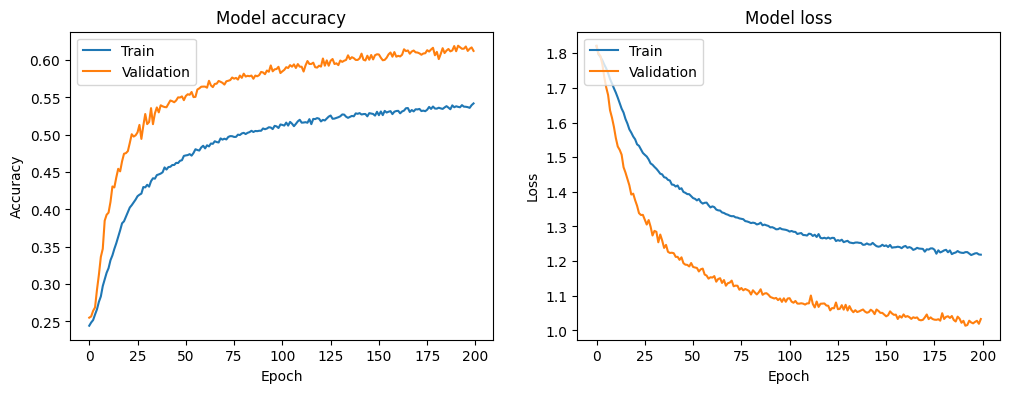

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history)


360/360 [==============================] - 3s 8ms/step


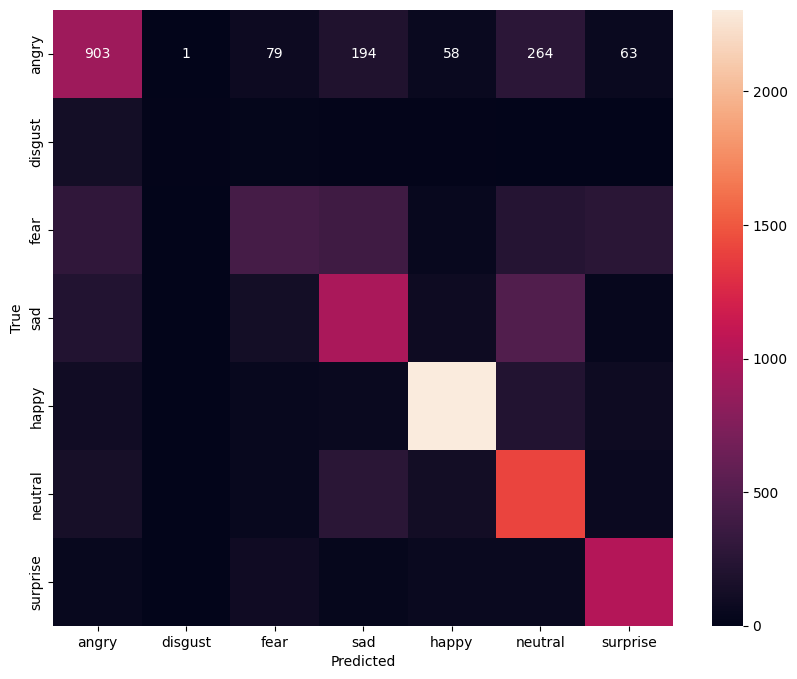

              precision    recall  f1-score   support

       angry       0.49      0.58      0.53      1562
     disgust       0.86      0.06      0.11       196
        fear       0.50      0.26      0.34      1642
         sad       0.51      0.50      0.51      1934
       happy       0.86      0.82      0.84      2816
     neutral       0.53      0.69      0.60      2050
    surprise       0.66      0.78      0.72      1306

    accuracy                           0.61     11506
   macro avg       0.63      0.53      0.52     11506
weighted avg       0.62      0.61      0.60     11506



In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_names = list(emotion_labels.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [ ]:
# Define the model with adjusted architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),  # Added another Conv layer
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),  # Increased Dense layer size
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile with a different learning rate
optimizer = Adam(learning_rate=0.0001)  # Decreased learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_names = list(emotion_labels.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [ ]:
# 2nd train

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.8, 1.2]
)
datagen.fit(X_train)

In [ ]:
# Transfer Learning with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Build model on top of VGG16
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [ ]:
# Freeze the base model layers
base_model.trainable = False

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [ ]:
# Train the model
batch_size = 64
epochs = 30

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[reduce_lr, checkpoint]
)

# Load the best model
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')